+ [Using google's Lightweight MMM packag with channel/adstock tuning and exporting modelled response curves](https://colab.research.google.com/drive/1zKHmT_CR6AmVbH-4PdsmUJdumMadcmrO#scrollTo=WcYeesq4w3jT)


+ [Simple End to End Demo](https://github.com/google/lightweight_mmm/blob/main/examples/simple_end_to_end_demo.ipynb)

In [29]:
# Import jax.numpy and any other library we might need.
import jax.numpy as jnp
import numpyro
import pandas as pd
import numpy as np
from jax.random import PRNGKey

# Import the relevant modules of the library
from lightweight_mmm import lightweight_mmm
from lightweight_mmm import plot
from lightweight_mmm import preprocessing
from lightweight_mmm import utils

from prjpkg import globalsettings as gs
from prjpkg.tools import highlight_low_spend_fractions, highlight_variances, highlight_high_vif_values

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Precision 64

In [30]:
# https://github.com/google/lightweight_mmm/issues/136
# https://github.com/google/jax/issues/9574
# https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#double-64bit-precision

from jax.config import config
config.update('jax_enable_x64', True)

# Data

## Creating Synthetic Media and external factors

In [31]:
SEED = 105
channel_names=['social','tv', 'sem', 'display', 'programmatic']

data_size = (52*3) + 26 # we'll be using 3 years of weekly data for trainingdata, and adding half a year as our test data
n_media_channels = len(channel_names)
n_extra_features = 5

In [32]:
media_data, extra_features, target, costs = utils.simulate_dummy_data(
    data_size        = data_size,
    n_media_channels = n_media_channels,
    n_extra_features = n_extra_features)

In [33]:
# Split and scale data.
split_point = data_size - 26

# Media data
media_data_train = media_data[:split_point, ...]
media_data_test  = media_data[split_point:, ...]

# Extra features
extra_features_train = extra_features[:split_point, ...]
extra_features_test  = extra_features[split_point:, ...]

# Target
target_train = target[:split_point]

## Scaling of data

In [34]:
media_scaler          = preprocessing.CustomScaler(divide_operation=jnp.mean)
extra_features_scaler = preprocessing.CustomScaler(divide_operation=jnp.mean)
target_scaler         = preprocessing.CustomScaler(divide_operation=jnp.mean)
cost_scaler           = preprocessing.CustomScaler(divide_operation=jnp.mean)

media_data_train     = media_scaler.fit_transform(media_data_train)
extra_features_train = extra_features_scaler.fit_transform(extra_features_train)
target_train         = target_scaler.fit_transform(target_train)
costs                = cost_scaler.fit_transform(costs)

## Checking data quality

In [35]:
correlations, variances, spend_fractions, variance_inflation_factors = preprocessing.check_data_quality(
    media_data          = media_scaler.transform(media_data),
    target_data         = target_scaler.transform(target),
    cost_data           = costs,
    extra_features_data = extra_features_scaler.transform(extra_features))

In [36]:
correlations[0].style.background_gradient(cmap='RdBu', vmin=-1, vmax=1).format(precision = 2)

,feature_0,feature_1,feature_2,feature_3,feature_4,extra_feature_0,extra_feature_1,extra_feature_2,extra_feature_3,extra_feature_4,target
feature_0,1.00,0.10,-0.10,-0.04,-0.05,-0.02,0.08,-0.08,-0.00,-0.10,0.08
feature_1,0.10,1.00,-0.13,0.02,0.10,0.11,0.06,0.08,-0.15,-0.07,0.19
feature_2,-0.10,-0.13,1.00,0.01,-0.06,-0.12,-0.09,-0.02,-0.06,0.04,-0.15
feature_3,-0.04,0.02,0.01,1.00,0.17,0.02,-0.04,0.14,0.08,-0.02,0.16
feature_4,-0.05,0.10,-0.06,0.17,1.00,0.11,0.08,0.09,0.05,-0.07,0.26
extra_feature_0,-0.02,0.11,-0.12,0.02,0.11,1.00,-0.15,-0.03,0.05,0.07,0.02
extra_feature_1,0.08,0.06,-0.09,-0.04,0.08,-0.15,1.00,0.16,-0.15,-0.02,0.36
extra_feature_2,-0.08,0.08,-0.02,0.14,0.09,-0.03,0.16,1.00,-0.14,0.05,0.47
extra_feature_3,-0.00,-0.15,-0.06,0.08,0.05,0.05,-0.15,-0.14,1.00,0.08,-0.03
extra_feature_4,-0.10,-0.07,0.04,-0.02,-0.07,0.07,-0.02,0.05,0.08,1.00,0.23


In [37]:
variances.style.applymap(highlight_variances).format(precision = 4)

,geo_0
feature_0,0.0050
feature_1,0.0054
feature_2,0.0067
feature_3,0.0057
feature_4,0.0060
extra_feature_0,0.0381
extra_feature_1,0.0442
extra_feature_2,0.0432
extra_feature_3,0.0330
extra_feature_4,0.0397


In [38]:
spend_fractions.style.applymap(highlight_low_spend_fractions).format(precision = 4)

,fraction of spend
feature_0,0.1996
feature_1,0.1992
feature_2,0.2003
feature_3,0.2017
feature_4,0.1992


In [39]:
variance_inflation_factors.style.applymap(highlight_high_vif_values).format(precision = 4)

,geo_0
feature_0,1.0466
feature_1,1.0822
feature_2,1.0605
feature_3,1.0642
feature_4,1.0796
extra_feature_0,1.0742
extra_feature_1,1.0991
extra_feature_2,1.0902
extra_feature_3,1.0923
extra_feature_4,1.0360


# Models

## Default Model

In [40]:
# Fit model.

mmm = lightweight_mmm.LightweightMMM(
    model_name         = "hill_adstock")

mmm.fit(media          = media_data_train,
        extra_features = extra_features_train,
        media_prior    = costs,
        target         = target_train,
        number_warmup  = 1000,
        number_samples = 1000,
        number_chains  = 2,
        )

c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\lightweight_mmm\lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [06:08<00:00,  5.43it/s, 1023 steps of size 6.33e-04. acc. prob=0.94]


In [63]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]      0.01      0.01      0.01     -0.00      0.02     75.02      1.00
             coef_extra_features[1]      0.04      0.01      0.04      0.03      0.05     84.90      1.01
             coef_extra_features[2]      0.05      0.01      0.05      0.04      0.06    117.51      1.00
             coef_extra_features[3]     -0.01      0.01     -0.01     -0.02      0.01     86.07      1.02
             coef_extra_features[4]      0.04      0.01      0.04      0.03      0.05    118.51      1.02
                      coef_media[0]      1.34      0.60      1.23      0.43      2.20     56.28      1.05
                      coef_media[1]      1.28      1.04      1.27      0.02      2.69      1.29      1.98
                      coef_media[2]      1.01      0.87      0.86      0.00      2.21      1.25      2.12
                      coef_media[3]      1.05

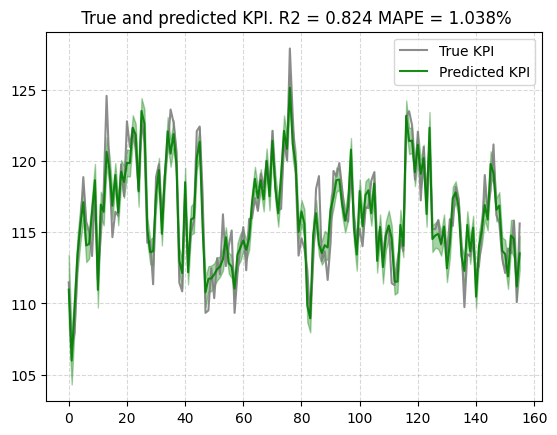

In [41]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

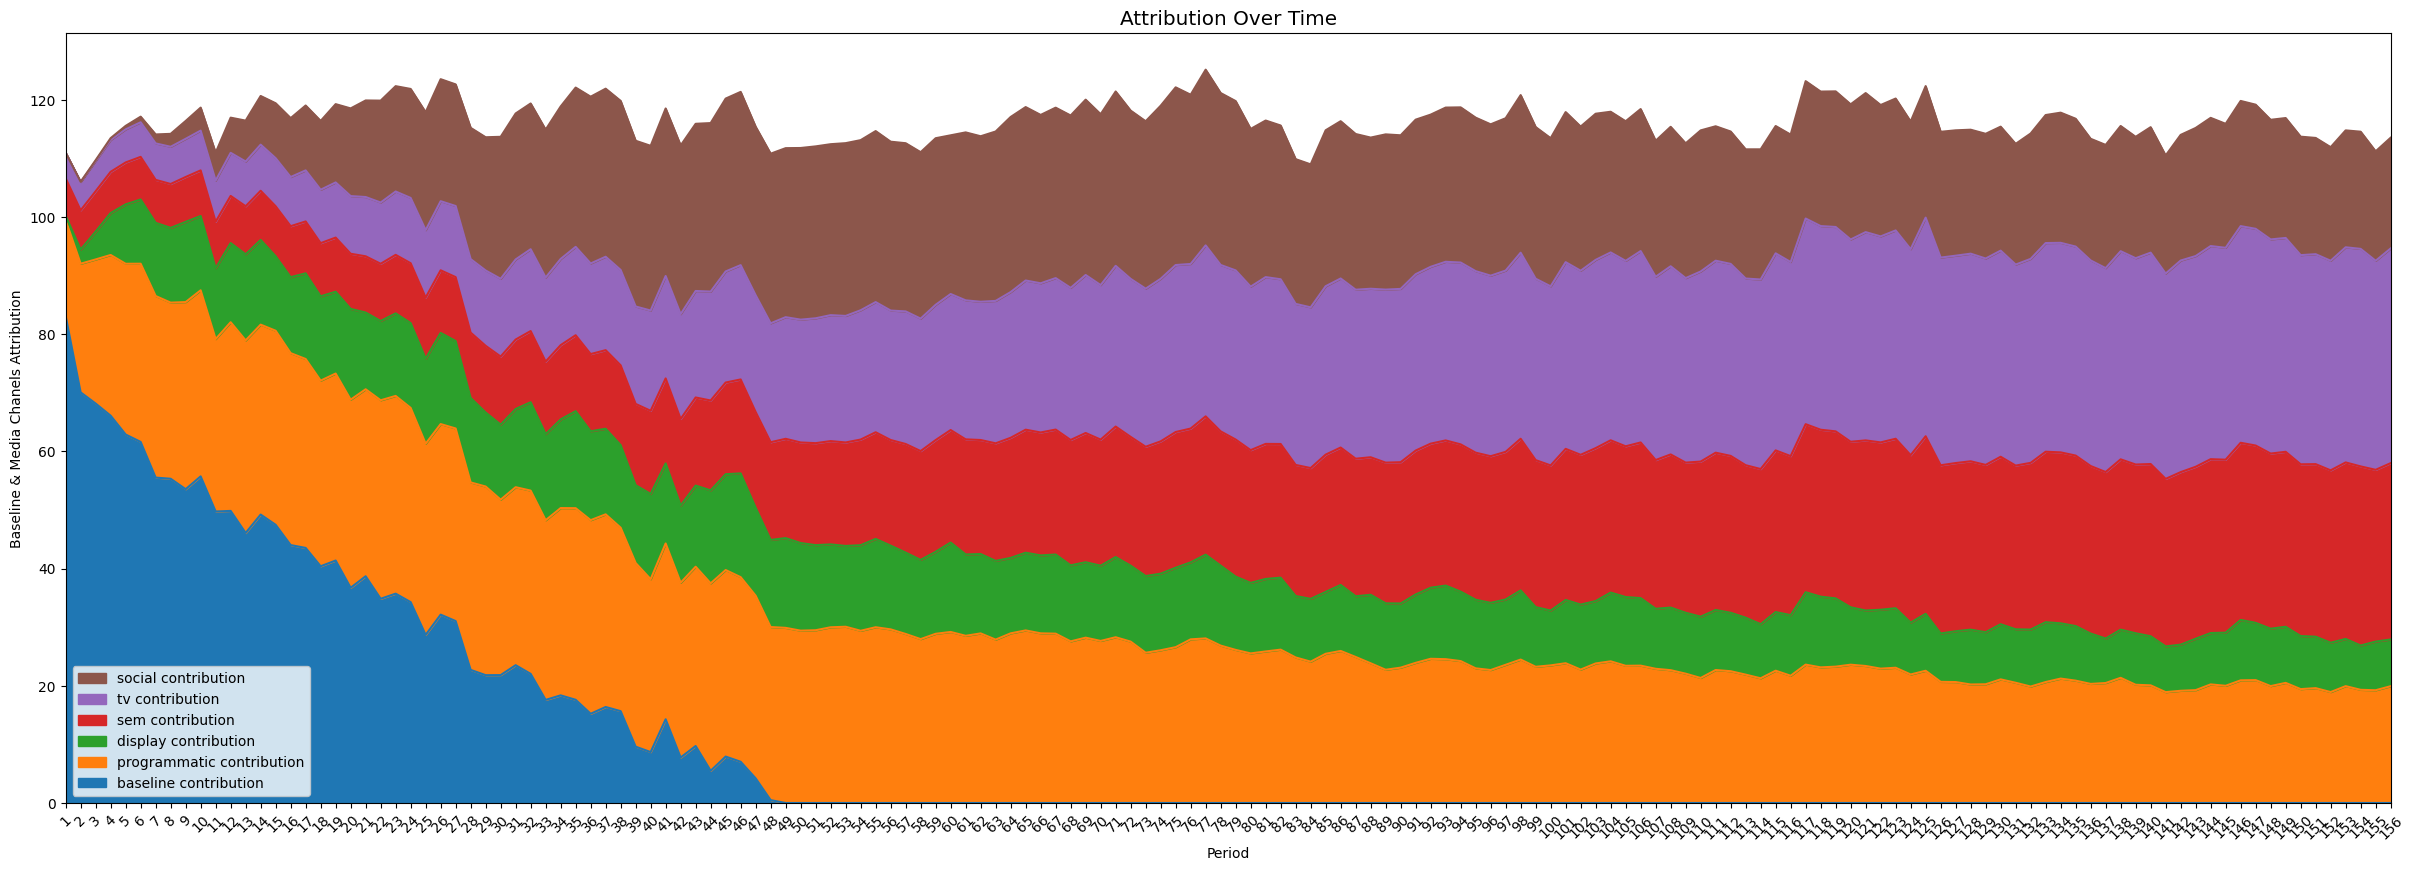

In [42]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model = mmm,
                                                target_scaler   = target_scaler,
                                                channel_names   = channel_names,
                                                fig_size        = (30,10))

In [68]:
contribs = plot.create_media_baseline_contribution_df(media_mix_model = mmm,
                                                      target_scaler   = target_scaler,
                                                      channel_names   = channel_names)

In [71]:
contribs.sum()

social_percentage               30.007261
tv_percentage                   33.550664
sem_percentage                  27.899832
display_percentage              15.753726
programmatic_percentage         34.980664
baseline_percentage             13.807853
avg_prediction               18125.245008
social contribution           3488.807911
tv contribution               3893.795945
sem contribution              3237.837973
display contribution          1833.908697
programmatic contribution     4067.297779
baseline contribution         1603.596704
period                       12246.000000
dtype: float64

In [43]:
media_contribution, roi_hat = mmm.get_posterior_metrics(target_scaler=target_scaler, cost_scaler=cost_scaler)

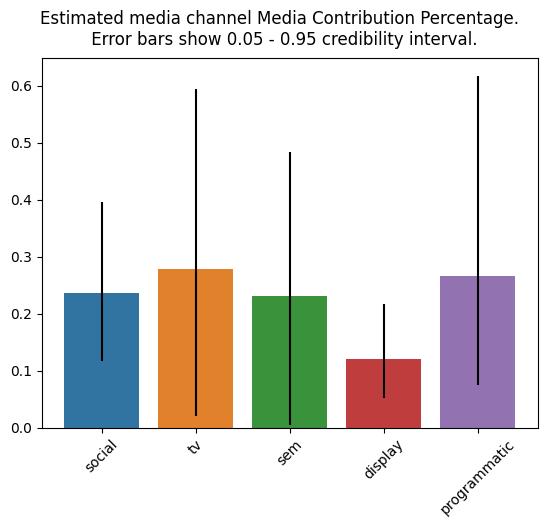

In [44]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage", channel_names   = channel_names)

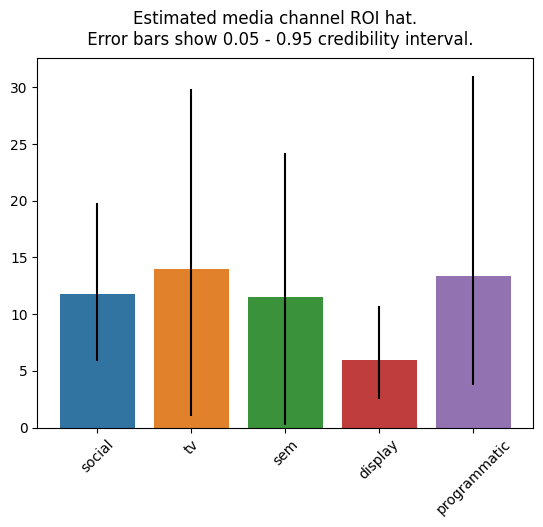

In [45]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names   = channel_names)

In [46]:
pd.DataFrame({'channels':channel_names, 'adstock_decay':mmm.trace['lag_weight'].mean(axis=0)})

,channels,adstock_decay
0,social,0.918011
1,tv,0.852709
2,sem,0.854393
3,display,0.686557
4,programmatic,0.574368


In [47]:
utils.save_model(media_mix_model=mmm, file_path="../../outputs/files/mmm_0")

In [61]:
# Once saved one can load the models.
loaded_mmm = utils.load_model(file_path="../../outputs/files/mmm_0")
loaded_mmm.trace["coef_media"].shape # Example of accessing any of the model values.

(2000, 5)

## Tune media priors

In [49]:
# PARA LAS BETA_MEDIA
channel_contribution_weights={
    'social':       1.,
    'tv':           0.5,
    'sem':          1.,
    'display':      1.,
    'programmatic': 1.
    }
mod_media_priors=jnp.array(list(channel_contribution_weights.values()))*costs

In [51]:
# Fit model.

mmm = lightweight_mmm.LightweightMMM(model_name = "hill_adstock")

mmm.fit(media          = media_data_train,
        extra_features = extra_features_train,
        media_prior    = mod_media_priors,
        target         = target_train,
        number_warmup  = 1000,
        number_samples = 1000,
        number_chains  = 2,
        )

c:\Users\migue\Documents\tst_lightweight\.venv\Lib\site-packages\lightweight_mmm\lightweight_mmm.py:358: UserWarning: There are not enough devices to run parallel chains: expected 2 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(2)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = numpyro.infer.MCMC(
sample: 100%|██████████| 2000/2000 [07:14<00:00,  4.60it/s, 1023 steps of size 1.15e-03. acc. prob=0.96]


In [60]:
mmm.print_summary()


                                         mean       std    median      5.0%     95.0%     n_eff     r_hat
             coef_extra_features[0]      0.01      0.01      0.01     -0.00      0.02     59.92      1.05
             coef_extra_features[1]      0.04      0.01      0.04      0.03      0.05     69.36      1.07
             coef_extra_features[2]      0.05      0.01      0.05      0.04      0.06    148.92      1.01
             coef_extra_features[3]     -0.00      0.01     -0.00     -0.01      0.01    164.98      1.03
             coef_extra_features[4]      0.04      0.01      0.04      0.03      0.05    157.10      1.01
                      coef_media[0]      1.15      0.59      1.04      0.28      2.06     27.14      1.11
                      coef_media[1]      0.42      0.29      0.36      0.01      0.81     18.10      1.11
                      coef_media[2]      1.86      0.61      1.82      0.87      2.85    126.81      1.01
                      coef_media[3]      1.00

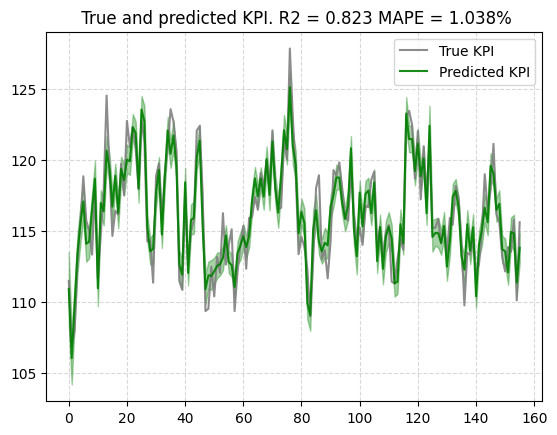

In [52]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

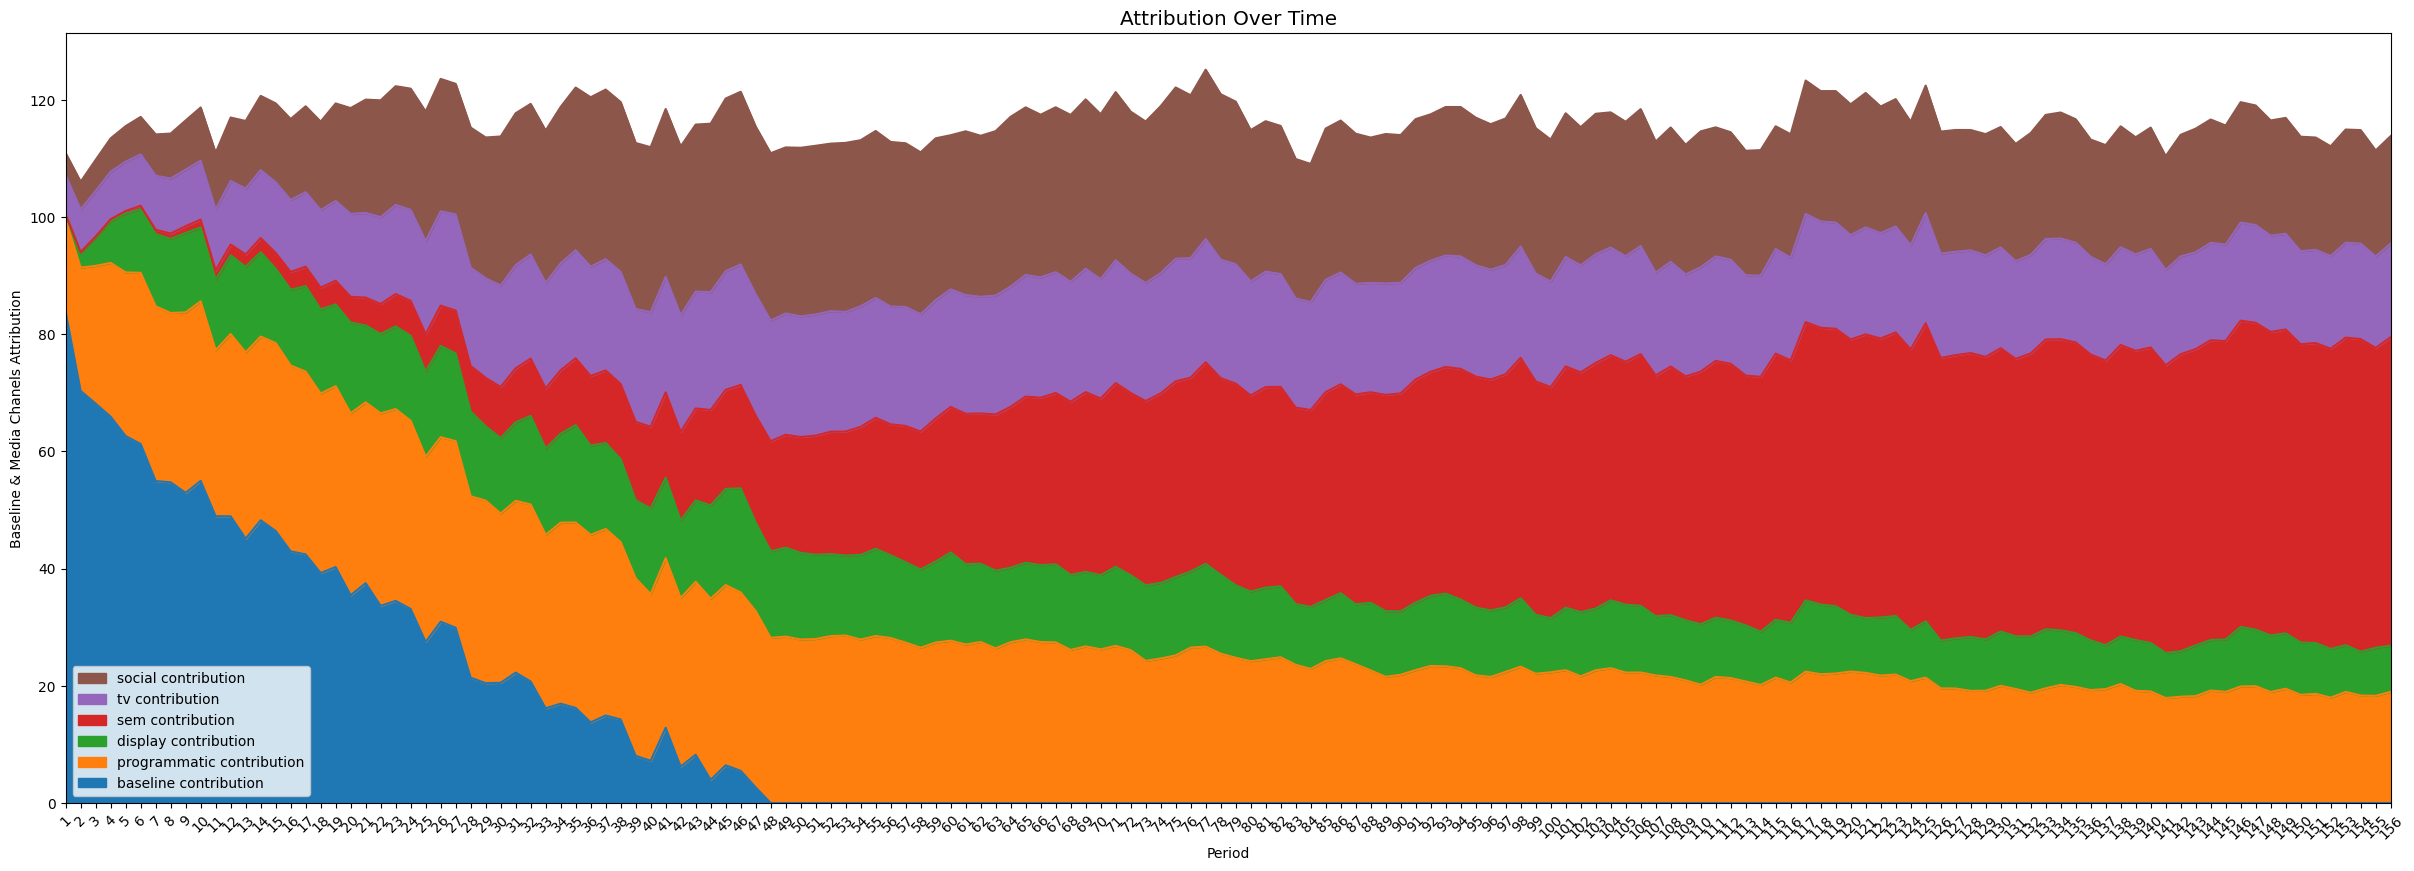

In [53]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model = mmm,
                                                target_scaler   = target_scaler,
                                                channel_names   = channel_names,
                                                fig_size        = (30,10))

In [72]:
contribs = plot.create_media_baseline_contribution_df(media_mix_model = mmm,
                                                      target_scaler   = target_scaler,
                                                      channel_names   = channel_names)

In [73]:
contribs.sum()

social_percentage               30.227358
tv_percentage                   23.335916
sem_percentage                  40.022911
display_percentage              15.626520
programmatic_percentage         33.406885
baseline_percentage             13.380410
avg_prediction               18124.739995
social contribution           3514.163984
tv contribution               2711.267329
sem contribution              4642.278446
display contribution          1819.123669
programmatic contribution     3884.532273
baseline contribution         1553.374295
period                       12246.000000
dtype: float64

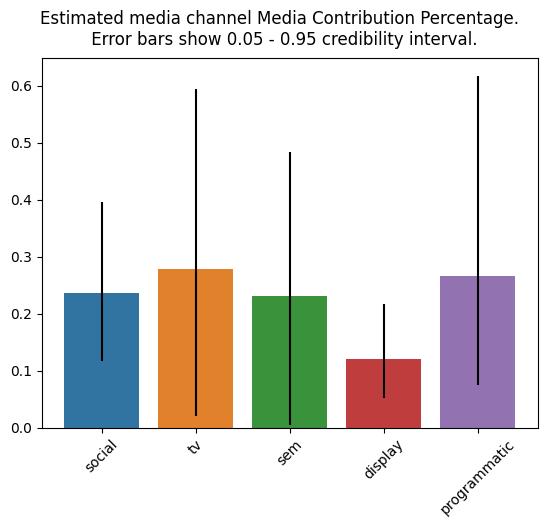

In [54]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage", channel_names   = channel_names)

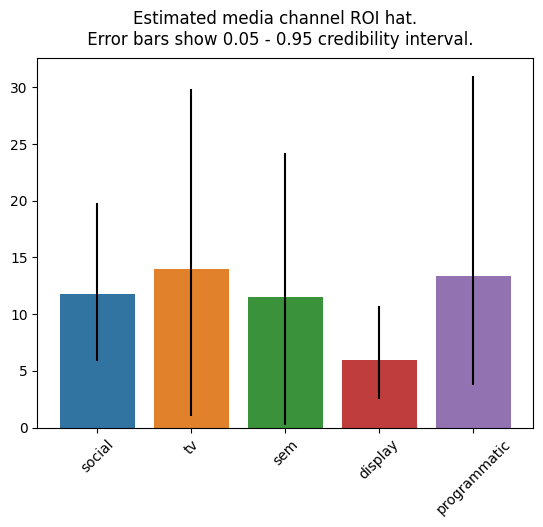

In [55]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names   = channel_names)

In [56]:
pd.DataFrame({'channels':channel_names, 'adstock_decay':mmm.trace['lag_weight'].mean(axis=0)})

,channels,adstock_decay
0,social,0.838315
1,tv,0.798208
2,sem,0.996298
3,display,0.691295
4,programmatic,0.578747


In [57]:
utils.save_model(media_mix_model=mmm, file_path="../../outputs/files/mmm_mp")

In [64]:
# Once saved one can load the models.
loaded_mmm = utils.load_model(file_path="../../outputs/files/mmm_mp")
loaded_mmm.trace["coef_media"].shape # Example of accessing any of the model values.

(2000, 5)

## Tune adstock

## Tune Hill

## Custom Priors Model

In [ ]:
# See detailed explanation on custom priors in our documentation. https://lightweight-mmm.readthedocs.io/en/latest/custom_priors.html
# trailing setting custom concentration weights for half effective concentration

# PARA LAS BETA_MEDIA
channel_contribution_weights={
    'social':       1.,
    'tv':           0.5,
    'sem':          1.,
    'display':      1.,
    'programmatic': 1.
    }
mod_media_priors=jnp.array(list(channel_contribution_weights.values()))*costs

# PARA LOS LAG_WEIGHTS
channel_adstock_weights={
    'social':       2.,
    'tv':           2.,
    'sem':          0.01, ## It is commonly assumed that SEM has little to no adstock decay in the industry due to user browsing habits. The default beta is 2
    'display':      2.,
    'programmatic': 2.
    }
adstock_lag_weight_priors=jnp.array(list(channel_adstock_weights.values()))

# PARA LAS K (HALF_EFF)
media_concentration_weights={
    'social':       1.,
    'tv':           0.8,
    'sem':          0.5,
    'display':      1.,
    'programmatic': 1.
    }

media_concentration_weights_priors=jnp.array(list(media_concentration_weights.values()))

custom_priors = {
    "lag_weight": numpyro.distributions.Beta(concentration1 = adstock_lag_weight_priors, 
                                             concentration0 = jnp.ones(len(adstock_lag_weight_priors))),
    "half_max_effective_concentration": numpyro.distributions.Gamma(concentration = media_concentration_weights_priors, 
                                                                    rate          = jnp.ones(len(media_concentration_weights_priors),))
                 }

# Fit model.

mmm = lightweight_mmm.LightweightMMM(model_name = "hill_adstock")

mmm.fit(media          = media_data_train,
        extra_features = extra_features_train,
        media_prior    = mod_media_priors,
        target         = target_train,
        number_warmup  = 1000,
        number_samples = 1000,
        number_chains  = 2,
        custom_priors  = custom_priors
        )

In [ ]:
plot.plot_model_fit(mmm, target_scaler=target_scaler)

In [ ]:
plot.plot_media_baseline_contribution_area_plot(media_mix_model = mmm,
                                                target_scaler   = target_scaler,
                                                channel_names   = channel_names,
                                                fig_size        = (30,10))

In [ ]:
plot.plot_bars_media_metrics(metric=media_contribution, metric_name="Media Contribution Percentage", channel_names   = channel_names)

In [ ]:
plot.plot_bars_media_metrics(metric=roi_hat, metric_name="ROI hat", channel_names   = channel_names)

In [ ]:
pd.DataFrame({'channels':channel_names, 'adstock_decay':mmm.trace['lag_weight'].mean(axis=0)})

In [ ]:
utils.save_model(media_mix_model=mmm, file_path="../../outputs/files/mmm_cp")

In [ ]:
# Once saved one can load the models.
loaded_mmm = utils.load_model(file_path="../../outputs/files/mmm_cp")
loaded_mmm.trace["coef_media"].shape # Example of accessing any of the model values.

# Volvemos a precision 32

In [ ]:
# https://github.com/google/lightweight_mmm/issues/136

from jax.config import config
config.update('jax_enable_x64', False)